# Grid Cell Phase Coding 

"Phases are in radians, coordinates are in [m] and time base is [ms].
The first data point in XYspkT corresponds with the first spike, which also corresponds with the first phase value and so on. So those files should have the same number of rows and if you merge them as columns each row should correspond with the same spike event.
So here is an important detail to pay attention to. __Because the spike times in the file are not in an ascending order but in the order of cells combined (like cell1 t1, cell1 t2, cell1 t3,..., cell2 t1, cell2 t2, cell2 t3,...)  if you sort them you will need to reindex the XYspkT and Phase data too.__
Or you just leave them as they are. Then they remain aligned.
 
The ultimate task is to predict the place where the avatar goes next based on the phase of the next spike. We have all the info we need. We know where the avatar is in space (X,Y), we know the phase of the next spike and we know the average map of all phases. We just need to find where the next spike would best fit on that map of opportunities based on average phases. Because average phases tessellate like grids, therefore for a given spike phase there are multiple spots in the field where that spike can ideally land. Of course the real landing spot is  one that is nearby, since the avatar does not jump. So we need to look the map of average phases at the local neighborhood and find the best match between the actual phase and the average phase map. The vector between the avatar's actual position and the predicted position (i.e the position where the phase of next spike would best match) defines a vector of moving direction. These are the small arrows in my plot.

An example:  
Let say the spike that just happened at t0 was generated at 30 degree (0.5236 rad) of the ongoing gamma cycle. We know the avatar's spatial position (X,Y). We also know that next spike t1 will be generated at 45 degree but we don't know at what spatial position. So we are considering the next 6 spikes (where 6 is an arbitrary number)  or a 5 x 5 m area around the spike (where 5 is an arbitrary metric) and try to find a tile with the average phase that best fit to the phase of next spike. That tile would be our best guess for the next position of the avatar.

Of course, for a cross-validation purpose, we will need to divide the data into a training set and decoding set (or predicting set). That will be the second step. But for start, let's just try to decode the phase using the entire 5 min data."


### TODO: add firing map, only look at low variance phase map, different environments, smaller matrix, consider rounding of XYspkT (up to preserve + amplify small movements?), generate new phasemap

### pay critical attention to whether coordinates in numpy [-y,x] or Cartesian [x,y]

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from astropy.stats import circcorrcoef
import astropy.units as u

%matplotlib inline
np.set_printoptions(suppress=True)
%config InLineBackend.figure_format = 'retina'

In [3]:
dir = 'datasets/1/'

#Spatial or temporal analysis
spatial = False

## XYspkT

XYspkT contains the X,Y coordinates of spikes. Spikes from all 30 neurons are combined in a single spike train. The X and Y columns represent the avatar's X-Y coordinate in [m] relative to the environment at the moment of the spike. 

XYspkT is float values, can be converted to integer with np.round(scaled_XY) as the coarse spatial analysis from the adjacency matrix only results in integer movement predictions

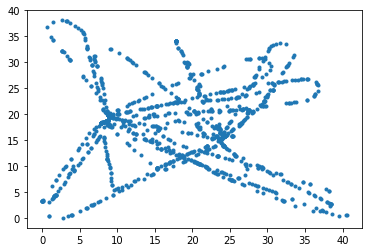

In [4]:
XYspkT = np.loadtxt(dir+'XYspkT.csv',delimiter=',')

#Aligns positions to [0,0] in the bottom-left corner
XYspkT[:,1] -= XYspkT[:,1].min()
XYspkT[:,0] -= XYspkT[:,0].min()
scaled_XY = XYspkT/2

plt.plot(scaled_XY[:,0],scaled_XY[:,1],'.')

## spkT

spkT contains the times of the spikes in ms

In [5]:
spkT = np.loadtxt(dir+'spkT.csv',delimiter=',')
print(spkT)
spkT.shape

[ 27466.  29501.  36602. ... 288400. 295600. 297440.]


(1178,)

## Phase

Phase is the corresponding (gamma) phase of the spikes - what phase the gamma oscillation was at them moment of spike

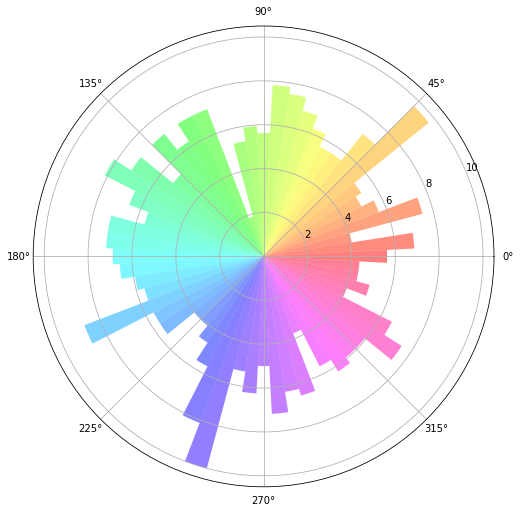

In [6]:
phase = np.loadtxt(dir+'Phase.csv',delimiter=',')
scaled_phase = phase-3.14

phase_degrees = np.degrees(phase)
sorted_phase = np.sort(phase_degrees)


#Radial histogram of phase distribution
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
theta = np.radians(np.arange(0,366,6))

inds = [np.where(sorted_phase<i)[0][-1] for i in np.arange(6,366,6)] #vectorize operation?
b = np.split(sorted_phase,inds)
radii = np.array([i.size/3.2 for i in b])

width = np.radians(360/60)
bars = ax.bar(theta, radii, width=width, bottom=0.0)
for theta, bar in zip(theta, bars):
    bar.set_facecolor(plt.cm.hsv(theta/6.28))
    bar.set_alpha(0.5)

plt.show()

## MeanPhaseMap

MeanPhaseMap the map of gamma phases. This is a 40x43 matrix that represents the 80x86 m land of the desert, the area covered by the avatar's navigation. The lot of NaN data correspond with areas never visited. A given value at the n-th row and m-th column represents the average phase of spikes (all spikes) within that area during the entire 5 min navigation. 

TODO:

-(time based meanphasemap of first half, traj from second)

-average internode distance

C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


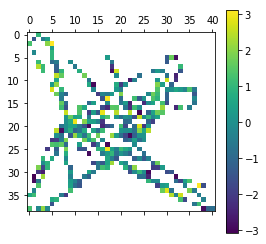

In [7]:
def mean_phase_map(arr,bin_size):
    mpm_dict = {}
    for ybin in range(0,int(arr[:,1].max()+1),bin_size):
        mpm_dict[ybin] = {}
        for xbin in range(0,int(arr[:,0].max()+1),bin_size):
            phases = []
            mpm_dict[ybin][xbin] = []
            for spike in arr:
                if (xbin <= spike[0] <= xbin+bin_size) and (ybin <= spike[1] <= ybin+bin_size):
                    phases.append(spike[2])      
            mpm_dict[ybin][xbin] = np.nanmean(np.asarray(phases))
    return mpm_dict

mpm_arr = np.column_stack((XYspkT,scaled_phase))
mpm_dict = mean_phase_map(mpm_arr,2)

#Rotate the dataframe 90 CCW
mpm = pd.DataFrame.from_dict(mpm_dict).T
phase_df = mpm.reindex(index=mpm.index[::-1])

arena_size = phase_df.shape

plt.matshow(phase_df)

#To-do: reflect radians in bar
plt.colorbar()

## Binned Phase Map

In [694]:
def remove_singles(array):
    has_neighbor = np.zeros(array.shape, bool)
    has_neighbor[:, 1:] = np.logical_or(has_neighbor[:, 1:], array[:, :-1] > 0)  # left
    has_neighbor[:, :-1] = np.logical_or(has_neighbor[:, :-1], array[:, 1:] > 0)  # right
    has_neighbor[1:, :] = np.logical_or(has_neighbor[1:, :], array[:-1, :] > 0)  # above
    has_neighbor[:-1, :] = np.logical_or(has_neighbor[:-1, :], array[1:, :] > 0)  # below

    array[np.logical_not(has_neighbor)] = 0
    return array

In [695]:
MPM3 = (MeanPhaseMap>2)*1
filtered_MPM3 = remove_singles(MPM3)
plt.matshow(filtered_MPM3)

NameError: name 'MeanPhaseMap' is not defined

In [ ]:
MPM2 = ((MeanPhaseMap>1) & (MeanPhaseMap<2))*1
filtered_MPM2 = remove_singles(MPM2)
plt.matshow(filtered_MPM2)

In [ ]:
MPM1 = ((MeanPhaseMap>0) & (MeanPhaseMap<1))*1
filtered_MPM1 = remove_singles(MPM1)
plt.matshow(filtered_MPM1)

## xyPos
xyPos is the trajectory traveled by the avatar. Each row is an X-Y data pair in [m] sampled in every ms. It is the biggest file because of the density of points. You can down-sample it to make it more manageable.

[[30.8703  33.9996 ]
 [30.8703  33.9996 ]
 [30.8703  33.9996 ]
 ...
 [52.412   35.49039]
 [52.354   35.38029]
 [52.295   35.27064]]


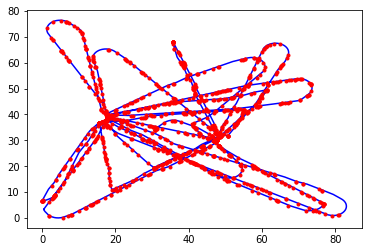

In [8]:
xyPos = np.loadtxt(dir+'xyPos.csv',delimiter=',')[::25]
xyPos[:,1]-= xyPos[:,1].min()
xyPos[:,0]-= xyPos[:,0].min()
print(xyPos)

#Trajectory overlaid with XYspkT
plt.plot(xyPos[:,0],xyPos[:,1], color='b')
plt.plot(XYspkT[:,0],XYspkT[:,1], '.', color='r', markersize=6)

## MeanPhaseMap DataFrame


In [9]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
phase_df

,0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,66,68,70,72,74,76,78,80
76,NaN,NaN,0.98440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,NaN,-1.413100,NaN,-0.466983,0.335000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,1.3020,NaN,NaN,NaN,2.011800,3.105600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,NaN,NaN,NaN,NaN,NaN,0.321367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,NaN,-0.184067,NaN,NaN,NaN,0.965550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,NaN,NaN,NaN,NaN,NaN,0.958800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.300641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.344500,1.689700,-2.868450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,NaN,NaN,1.08250,NaN,NaN,-0.874700,-0.530400,NaN,NaN,-0.043690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.577800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.337150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,NaN,NaN,2.38180,1.084200,NaN,NaN,-1.112347,NaN,NaN,NaN,-0.548400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.137240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.06550,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,1.131200,NaN,NaN,-1.291834,0.954200,NaN,NaN,NaN,0.788480,NaN,NaN,NaN,NaN,NaN,NaN,-2.860160,2.662500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.700000,0.206900,-0.379214,NaN,NaN,NaN,-1.42060,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,NaN,NaN,NaN,NaN,NaN,NaN,2.495100,1.615100,NaN,NaN,NaN,NaN,1.763900,NaN,NaN,NaN,NaN,NaN,NaN,-0.142860,NaN,NaN,NaN,NaN,-0.774550,NaN,NaN,NaN,NaN,NaN,-0.738620,NaN,-2.469384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#A padded phase map for use in edge-cases for extracting the 5x5 adjacency matrix below
padded_phase_map = np.pad(phase_df,pad_width=2,mode='constant',constant_values=np.nan)
padded_phase_df = pd.DataFrame(data=padded_phase_map)
padded_phase_df.shape



(43, 45)

### Adjacent Matrix Function

Returns a 5x5 array to analyze a region of space adjacent to a target location within the MeanPhaseMap, then finds
the x and y difference from the center to cell to the cell with the cloest matching value (of phase).

example return array:

       [ 3.0844,     nan, -1.5684,     nan,     nan],

       [ 3.0844,     nan,     nan, -1.6837, -1.5763],
       
       [    nan,     nan,     nan,     nan, -1.5088],
       
       [-2.8458,     nan,     nan,     nan, -2.5082],
       
       [-2.8458,     nan,     nan,     nan,     nan]

In [11]:
def adjacent_matrix(cell):
    x = int(cell[0])
    y = int(cell[1])
    y_size = arena_size[0]-1
    a = padded_phase_df.iloc[y_size-y:y_size-y+5,x:x+5]
    
    return a

def adjacent_spikes(spikes, phase):
    
    #get location of spike with most similar phase
    y_size = arena_size[0]-1
    phases = []
    for i in spikes:
        x = int(i[0])
        y = int(i[1])
        phases.append(phase_df.iloc[y_size-y,x])
    phases = np.asarray(phases)

    try:
        nearest = np.nanargmin(np.abs(phases-phase))
    except:
        nearest = 0

    
    try:
        x = round(spikes[nearest][0])
        y = round(spikes[nearest][1])
        return [x-spikes[0,0],y-spikes[0,1]]
    
    except:
         return [0.0,0.0]
        
def nearest_phase(array,phase):
    
    #Determines change vector from central cell
    #to cell nearest in value in 7x7 IN FORM **[X,Y]**
    try:
        nearest = np.nanargmin(np.abs(array-phase))
        #loc = [(am%7)-3,3-(am//7)]
        loc = [(nearest%5)-2,2-(nearest//5)]
        return loc
    except:
        return [0,0]
    
#Tests:
#print(adjacent_matrix([3,0]))
#print(nearest_phase(adjacent_matrix([4,6]),3))
#print(phase_from_movement(adjacent_matrix([16,19]),0,0))
#adjacent_spikes(combined[10:16,1:3],combined[10,4])

## Combined Position, Time and Phase DataFrame

X,Y position, change in distance, time and phase data sorted by trajectory from the Time column in a dataframe

In [12]:
unsorted = np.column_stack((spkT,scaled_XY,scaled_phase))
sorted = unsorted[unsorted[:,0].argsort()]

#Calculate movement magnitudes
xdif = np.append(sorted[1:,1],0)-np.append(sorted[:-1,1],0)
ydif = np.append(sorted[1:,2],0)-np.append(sorted[:-1,2],0)

#Drop rows with movements below threshold
move_thresh = 0.3

raw = np.column_stack((sorted,xdif,ydif))
print(raw)
movement  = raw[np.any(abs(raw[:,4:]) >= move_thresh, axis=1)]

#Recalculate movement magnitudes
xdif = np.append(movement[1:,1],0)-np.append(movement[:-1,1],0)
ydif = np.append(movement[1:,2],0)-np.append(movement[:-1,2],0)
next_phase = np.insert(movement[1:,3],-1, 0)

combined = np.column_stack((movement[:,:4],next_phase,xdif,ydif))
print(combined)

[[    16.          15.43365     16.8938       1.4839       0.
       0.     ]
 [   127.          15.43365     16.8938       1.9293       0.
       0.     ]
 [   133.          15.43365     16.8938       2.8428       0.
       0.     ]
 ...
 [298520.          26.4205      18.04311     -0.2021      -0.08
      -0.14914]
 [298580.          26.3405      17.89397      3.14        -0.1275
      -0.2394 ]
 [298690.          26.213       17.65457      1.7533       0.
       0.     ]]
[[   275.           15.43365      16.8938   ...      0.0088
       0.24165       0.4045  ]
 [   907.           15.6753       17.2983   ...     -2.40195
       0.9843        0.983465]
 [  1495.           16.6596       18.281765 ...     -1.6251
       1.00415       0.481885]
 ...
 [297310.           27.5115       20.8144   ...      2.0308
      -0.177        -0.66675 ]
 [297590.           27.3345       20.14765  ...      0.
      -0.356        -1.0592  ]
 [298040.           26.9785       19.08845  ...     -1.1118
   

In [13]:
# Spatial Analysis
if spatial == True:
    predicted = [nearest_phase(adjacent_matrix([i[1],i[2]]),i[4]) for i in combined]
    predicted_movement = np.asarray(predicted)

# Temporal Analysis    
elif spatial == False:
    predicted = [adjacent_spikes(combined[i:i+6,1:3],combined[i,4]) for i in range(len(combined))]
    predicted_movement = np.asarray(predicted)
    
all=np.column_stack((combined,predicted_movement))
df = pd.DataFrame(data=all, columns=['Time','X','Y','Phase','Next Phase','Xdif','Ydif','Xdif Predicted', 'Ydif Predicted'])

df

,Time,X,Y,Phase,Next Phase,Xdif,Ydif,Xdif Predicted,Ydif Predicted
0,275.0,15.433650,16.893800,2.910600,0.008800,0.241650,0.404500,0.566350,0.106200
1,907.0,15.675300,17.298300,0.008800,-2.401950,0.984300,0.983465,1.324700,0.701700
2,1495.0,16.659600,18.281765,-2.401950,-1.625100,1.004150,0.481885,1.340400,0.718235
3,1950.0,17.663750,18.763650,-1.625100,-1.600100,0.512900,-0.006550,0.336250,0.236350
4,2157.0,18.176650,18.757100,-1.600100,-2.995360,0.733800,-0.272300,4.823350,-2.757100
5,2473.0,18.910450,18.484800,-2.995360,-0.064400,2.139300,-1.058855,2.089550,-1.484800
6,3432.0,21.049750,17.425945,-0.064400,-2.976890,1.676900,-1.278345,1.950250,-1.425945
7,4263.0,22.726650,16.147600,-2.976890,-0.596700,0.607400,-0.479200,0.273350,-1.147600
8,4574.0,23.334050,15.668400,-0.596700,-0.204200,0.484550,-0.524150,-2.334050,2.331600
9,6302.0,23.818600,15.144250,-0.204200,1.093200,-1.243600,0.143650,-2.818600,2.855750


In [14]:
def vector_angles(df):
    
    angles = []
    for index, row in df.iterrows():
        p0 = [row['Xdif'],row['Ydif']]
        p1 = [0,0]
        p2 = [row['Xdif Predicted'],row['Ydif Predicted']]
        v0 = np.array(p0) - np.array(p1)
        v1 = np.array(p2) - np.array(p1)
        atan = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
        angles.append(np.degrees(atan))
        
    return angles

In [15]:
np.mean(vector_angles(df))

1.6870417899729873

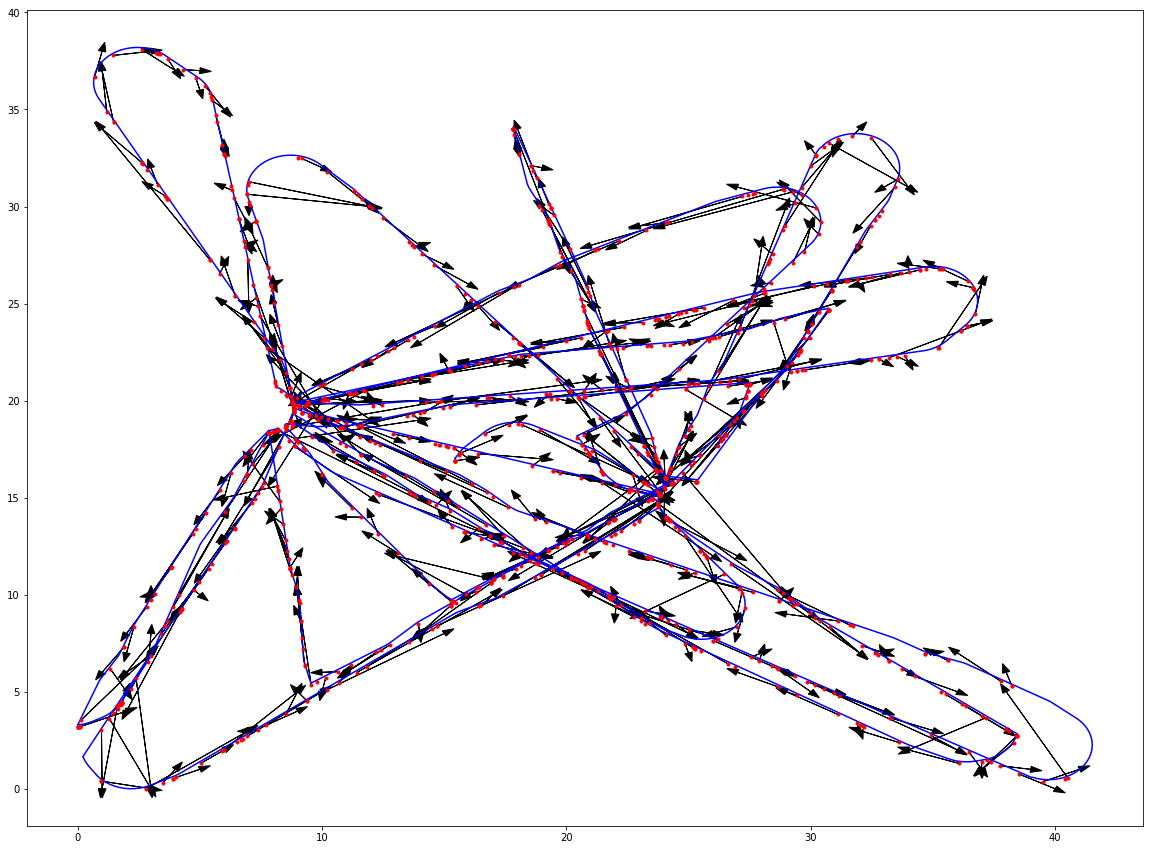

In [16]:
plt.rcParams['figure.figsize'] = [20,15]
plt.plot(xyPos[:,0]/2,xyPos[:,1]/2, color='b')
plt.plot(scaled_XY[:,0],scaled_XY[:,1], '.', color='r', markersize=6)
for index, row in df.iterrows():
    #if (row['Xdif Predicted']>0) or (row['Ydif Predicted']>0):
        plt.arrow(row['X'],row['Y'],row['Xdif Predicted'],row['Ydif Predicted'], head_width=3*width,color='black')


## Testing Area

In [17]:
#Determines the angle between the previous vector and current vector, returns [observed,predicted]
def rel_vector_angles(arr):
    
    obs_angles = []
    pred_angles = []
    
    for i in range(len(arr)-1):
        p0 = [all[i,1]+all[i,5],all[i,2]+all[i,6]]
        p1 = [all[i,1],all[i,2]]
        p2 = [all[i+1,1]+all[i+1,5],all[i+1,2]+all[i+1,6]]
        v0 = np.array(p0) - np.array(p1)
        v1 = np.array(p2) - np.array(p1)
        atan = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
        obs_angles.append(np.degrees(atan))
        
    for i in range(len(arr)-1):
        p0 = [all[i,1]+all[i,5],all[i,2]+all[i,6]]
        p1 = [all[i,1],all[i,2]]
        p2 = [all[i+1,1]+all[i+1,7],all[i+1,2]+all[i+1,8]]
        v0 = np.array(p0) - np.array(p1)
        v1 = np.array(p2) - np.array(p1)
        atan = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
        pred_angles.append(np.degrees(atan))
        
    return(list(zip(obs_angles,pred_angles)))




In [18]:
#Determines the angle between the horizontal axis (+1 x, +0 y) and the current vector, returns [observed,predicted]
def abs_vector_angles(arr):
    
    obs_angles = []
    pred_angles = []
    
    for i in range(len(arr)-1):
        p0 = [all[i,1]+1,all[i,2]]
        p1 = [all[i,1],all[i,2]]
        p2 = [all[i+1,1],all[i+1,2]]
        v0 = np.array(p0) - np.array(p1)
        v1 = np.array(p2) - np.array(p1)
        atan = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
        if np.degrees(atan)<0:
            obs_angles.append(360+np.degrees(atan))
        else:
            obs_angles.append(np.degrees(atan))
        
    for i in range(len(arr)-1):
        p0 = [all[i,1]+1,all[i,2]]
        p1 = [all[i,1],all[i,2]]
        p2 = [all[i,1]+all[i,7],all[i,2]+all[i,8]]
        v0 = np.array(p0) - np.array(p1)
        v1 = np.array(p2) - np.array(p1)
        atan = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
        if np.degrees(atan)<0:
            pred_angles.append(360+np.degrees(atan))
        else:
            pred_angles.append(np.degrees(atan))
        
    return(list(zip(obs_angles,pred_angles)))



In [19]:
angles = np.asarray(abs_vector_angles(all))
print(angles.mean())
angles = angles[~np.all(angles == 0, axis=1)]
angles

177.30170441930716


array([[ 59.14572771,  10.6205715 ],
       [ 44.97568715,  27.91038528],
       [ 25.63604356,  28.18402259],
       ...,
       [  5.2003733 ,  10.85503545],
       [255.13278424,  20.80371626],
       [251.42236332, 203.816907  ]])

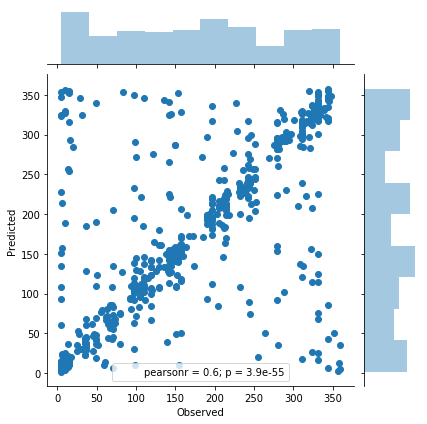

In [20]:
dt = pd.DataFrame(data=angles,columns=['Observed','Predicted'])
sns.jointplot(x='Observed',y='Predicted',data=dt)

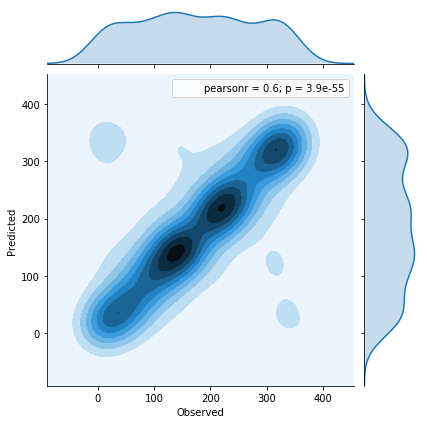

In [21]:
sns.jointplot(x='Observed',y='Predicted',data=dt,kind='kde')

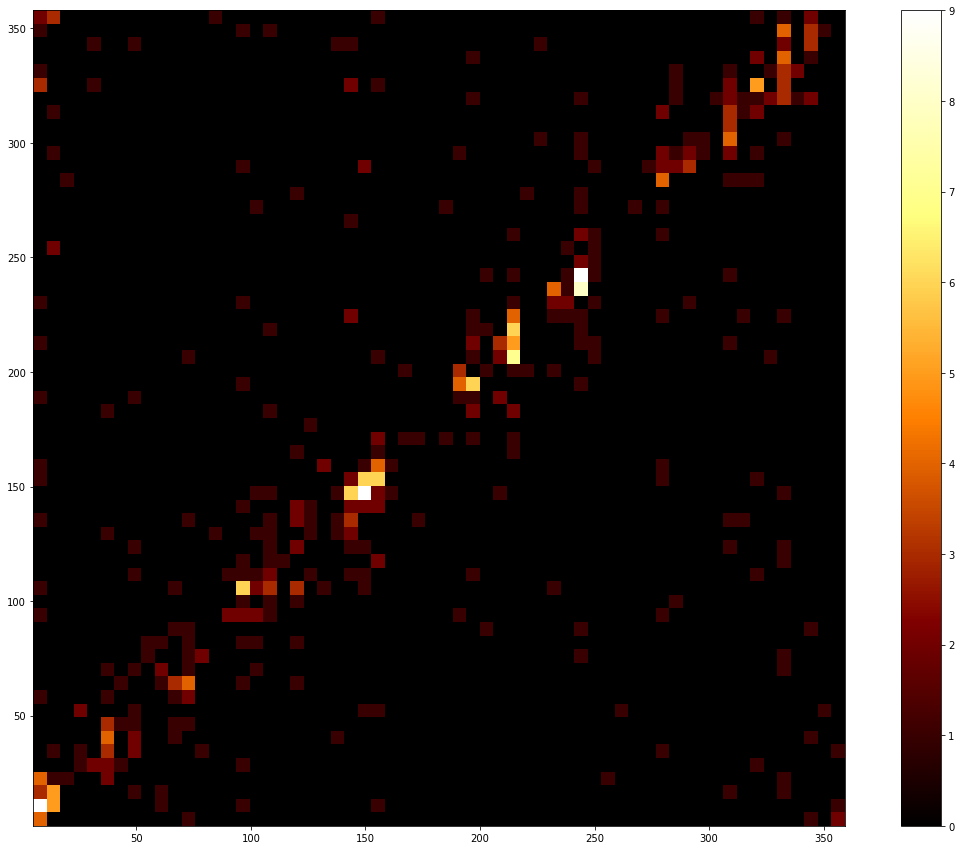

In [22]:
heatmap, xedges, yedges = np.histogram2d(angles[:,0], angles[:,1], bins=60)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower',cmap='afmhot')
plt.colorbar()
plt.show()


In [16]:
import analysis
import numpy as np
import matplotlib.pyplot as plt

In [1]:
r_scores = np.asarray([[analysis.gridCells('datasets/'+str(ii+1)+'/',i/10).phase_analysis() for i in range(11)] for ii in range(8)])

NameError: name 'np' is not defined

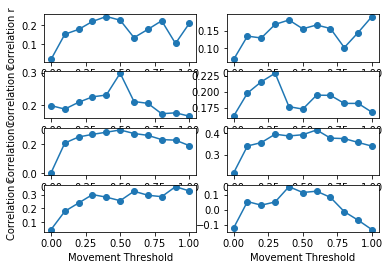

In [20]:
for ii in range(8):
    plt.subplot(4,2,ii+1)
    plt.plot([i/10 for i in range(11)],r_scores[ii],'.-',markersize=12)
    if ii in [0,2,4,6]:
        plt.ylabel('Correlation r')
    if ii in [6,7]:
        plt.xlabel('Movement Threshold')

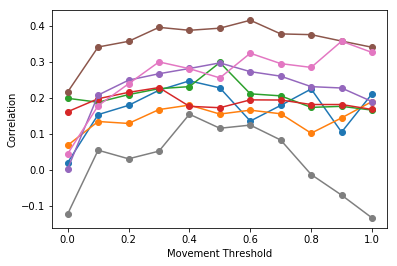

In [22]:
for ii in range(8):
    plt.plot([i/10 for i in range(11)],r_scores[ii],'.-',markersize=12)
    plt.ylabel('Correlation')
    plt.xlabel('Movement Threshold')

In [17]:
import fuckit

def firing_rate_map(arr,bin_size):
    fr_dict = {}
    for ybin in range(0,int(arr[:,1].max()+1),bin_size):
        fr_dict[ybin] = {}
        for xbin in range(0,int(arr[:,0].max()+1),bin_size):
            times = []
            fr_dict[ybin][xbin] = []
            for spike in arr:
                if (xbin <= spike[0] <= xbin+bin_size) and (ybin <= spike[1] <= ybin+bin_size):
                    times.append(spike[2]/1000)   
            
            # Group spikes by differences > 1000 ms
            split_inds = []
            times = np.unique(np.sort(times)) # Cases of same time?
            for i in range(len(times)):
                try:
                    if times[i+1]-times[i]>1:
                        split_inds.append(i+1)
                except:
                    pass
            spike_groups = np.split(times,np.unique(split_inds))
            
            # Find firing rate of each group by dividing the total count/duration
            rates = []
            for i in spike_groups:
                try:
                    a = len(i)
                    b = max(i)-min(i)
                    if b == 0:
                        b = 1
                    rates.append(a/b)
                except:
                    pass
            
            fr_dict[ybin][xbin] = np.asarray(rates).mean()
            
    return fr_dict

fr_arr = np.column_stack((XYspkT,spkT))
fr_dict = firing_rate_map(fr_arr,2)

C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


{0: {0: inf,
  2: [],
  4: inf,
  6: 15.957446808510436,
  8: inf,
  10: [],
  12: [],
  14: [],
  16: [],
  18: [],
  20: [],
  22: [],
  24: [],
  26: [],
  28: [],
  30: [],
  32: [],
  34: [],
  36: [],
  38: [],
  40: [],
  42: [],
  44: [],
  46: [],
  48: [],
  50: [],
  52: [],
  54: [],
  56: [],
  58: [],
  60: [],
  62: [],
  64: [],
  66: [],
  68: [],
  70: [],
  72: [],
  74: [],
  76: inf,
  78: inf,
  80: 39.999999999990905},
 2: {0: [],
  2: [],
  4: [],
  6: [],
  8: [],
  10: 6.493506493506447,
  12: [],
  14: [],
  16: [],
  18: [],
  20: [],
  22: [],
  24: [],
  26: [],
  28: [],
  30: [],
  32: [],
  34: [],
  36: [],
  38: [],
  40: [],
  42: [],
  44: [],
  46: [],
  48: [],
  50: [],
  52: [],
  54: [],
  56: [],
  58: [],
  60: [],
  62: [],
  64: [],
  66: [],
  68: [],
  70: [],
  72: 0.026003293750541733,
  74: 12.500000000001007,
  76: [],
  78: [],
  80: []},
 4: {0: [],
  2: [],
  4: [],
  6: [],
  8: [],
  10: inf,
  12: 19.607843137254157,
  14: [],
 

TypeError: Image data cannot be converted to float

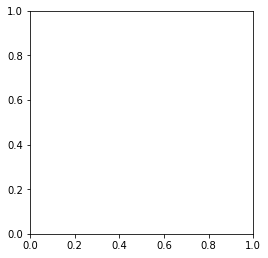

In [20]:
#Rotate the dataframe 90 CCW
frm = pd.DataFrame.from_dict(fr_dict).T
fr_df = frm.reindex(index=frm.index[::-1])

plt.matshow(fr_df)

#To-do: reflect radians in bar
plt.colorbar()

In [23]:
circcorrcoef(angles[:,0]*u.deg, angles[:,1]*u.deg)

<Quantity 0.40279188>